In [1]:
import pandas as pd
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.stats as ss
import seaborn as sns
plt.style.use('seaborn-darkgrid')
# disabling gpu for now
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

## Set-up Model Parameters

In [2]:
# load mobility matrix
data = pd.read_csv('../../../Dropbox/Epidemiology/trajectories/nys_commuting_counties.csv', index_col = 0).values
data = [i / np.sum(i) for i in data]
R = np.array(data)
M = R.shape[0]
np.sum(R, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [3]:
# Make up some populations (take as known)
population = np.maximum(1000, np.round(np.random.normal(loc=100000, scale=25000, size=(M,)), 0))
area = np.maximum(250, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
print(area, population)


[2665. 2359. 1057. 1728. 2505. 1542. 2425. 3070. 2117.  859. 1773. 1451.
 1863. 3613. 3058. 3350. 1465. 1840. 2380. 2123.  250. 1834. 2903. 3744.
 3126. 3215. 2032. 2647. 2735.  252. 2242.  250. 2972. 1652. 2528. 2646.
 2717. 1332. 2308. 3926. 2472. 2205. 1655.  389.  614.  750. 2240. 1502.
  946. 2049. 1675. 3243. 1272. 2108. 2344. 2553.  524. 2030. 1337. 1212.
  250. 2682.] [135479.  99124. 115435.  74432. 107785.  84849.  90142.  72299.  66889.
 117277.  84812. 140953. 108183. 107761.  68916. 100846. 105600. 124759.
 110099.  50379.  54762.  91925.  91911.  87444.  22566.  92301.  99627.
  88520. 139916.  28715. 120091. 138831. 104133.  84719. 109670.  78129.
 123555. 116644.  75629.  74470. 126955. 105389. 125737.  99292.  75733.
  82365.  82117. 125837. 102782.  85573.  83206.  82183. 126714.  63057.
  86417. 125462. 112576.  93153. 104898.  98269.  81144. 109497.]


In [4]:
# compartment parameters
compartments = ['E', 'A', 'I', 'R']
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 5, 3)
tmat.add_transition('A', 'I', 3, 3)
tmat.add_transition('I', 'R', 14, 5)
print(tmat.value)
np.sum(tmat.value, axis=1)

[[0.8        0.2        0.         0.        ]
 [0.         0.66666667 0.33333333 0.        ]
 [0.         0.         0.92857143 0.07142857]
 [0.         0.         0.         1.        ]]


array([1., 1., 1., 1.])

In [5]:
# starting fractions probabilities
start = np.zeros((M,)) - 10 #anywhere
start[0] = 5. # but likely 0

## Make starting joint

In [6]:
param_model = maxentep.MetaParameterJoint(start, R, tmat, name='unbiased')

## Examine some of the statistics

In [7]:
v = param_model.sample(100)

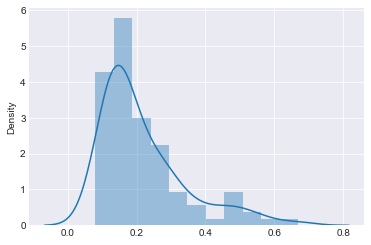

In [8]:
x = v[1][:,compartments.index('E'), compartments.index('A')].numpy()
sns.distplot(x=x)
plt.show()

In [9]:
np.mean(v[1][:, 0, 1]), 1/5

(0.21729946, 0.2)

In [10]:
# v[2][2]

In [11]:
# check transition matrix is valud
T = v[1][0].numpy()
print(T)
f = [0.1,0,0,0]
for i in range(1000):
    f = f @ T
    if i % 100 == 0:
        print(f, np.sum(f))

[[0.7664277  0.23357232 0.         0.        ]
 [0.         0.8328673  0.16713266 0.        ]
 [0.         0.         0.9507607  0.04923926]
 [0.         0.         0.         1.        ]]
[0.07664277 0.02335723 0.         0.        ] 0.10000000149011612
[2.14580473e-13 3.34236888e-09 1.09542488e-03 9.89045393e-02] 0.09999996753266431
[6.00771342e-25 3.81711066e-17 7.02599220e-06 9.99929412e-02] 0.09999996720328358
[1.68200862e-36 4.35830040e-25 4.50641152e-08 9.99999221e-02] 0.09999996720117099
[4.70920097e-48 4.97621971e-33 2.89037394e-10 9.99999669e-02] 0.0999999672011575
[1.31845780e-59 5.68174756e-41 1.85386121e-12 9.99999672e-02] 0.09999996720115739
[3.69135015e-71 6.48730506e-49 1.18905078e-14 9.99999672e-02] 0.09999996720115742
[1.03348518e-82 7.40707441e-57 7.62647036e-17 9.99999672e-02] 0.09999996720115739
[2.89349849e-94 8.45724855e-65 4.89155309e-19 9.99999672e-02] 0.09999996720115732
[8.10106783e-106 9.65631625e-073 3.13740046e-021 9.99999672e-002] 0.09999996720115732



## Create set of trajectories
The loop is just to batch the trajectories. It is not necessary, just I have my at home GPU which has small RAM.
You could instead just pick `N = 16 * 256` and call once.

In [12]:
import tqdm
#tf.debugging.enable_check_numerics()
N = 256
batches = 4
outs = []
timesteps = 360
infect_fxn = maxentep.contact_infection_func(infections_compartments, area=area)
model = MetaModel(infect_fxn, timesteps, populations=population)
for b in tqdm.tqdm(range(batches)):
    psample = param_model.sample(N)
    outs.append(model(*psample))
trajs = np.concatenate(outs, axis=0)
print(trajs.shape)

100%|███████████████████████████████████████████████████████████████████████████| 4/4 [00:17<00:00,  4.46s/it]

(1024, 360, 62, 5)


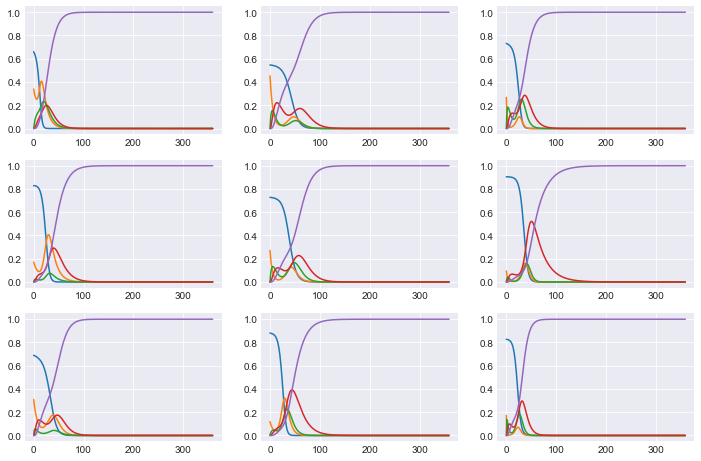

In [13]:
# plot a few trajectories
fig, ax = plt.subplots(3, 3, figsize=(12,8))
for i in range(3):
    for j in range(3):
        ax[i,j].plot(trajs[i * 3 + j,:,0,:])
plt.show()

## Make quantile Plots

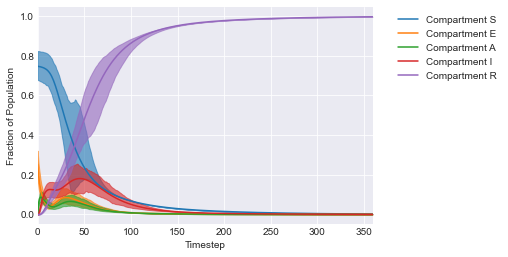

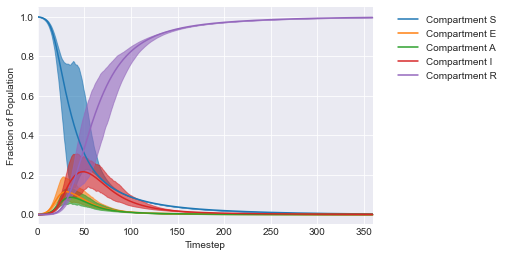

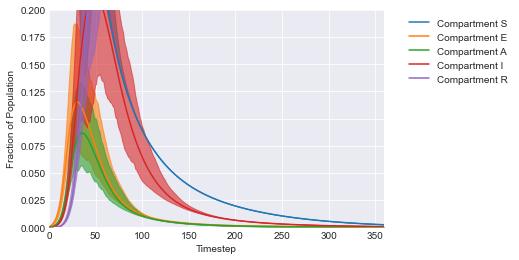

In [14]:
full_compartments = ['S'] + compartments
traj_quantile(trajs[:,:,0,:], names=full_compartments, plot_means=True)
plt.show()
traj_quantile(trajs[:,:,1,:], names=full_compartments, plot_means=True)
plt.show()
traj_quantile(trajs[:,:,2,:], names=full_compartments, plot_means=True)
plt.ylim(0,0.2)
plt.show()

## Create arbitrary restraints

In [15]:
restraints = np.array([
    [0.4, 0, 250, 0, 0],
    [0.12,0.05,200,2,1],
    [0.8, 0.1,300, 1, 4],
    [0.6, 0.1, 250, 34, 4],
    [0.4, 0.1, 250, 24, 0],
             ])
laplace_restraints = []
for i in range(len(restraints)):
    traj_index = tuple(restraints[i, 2:].astype(np.int))
    value = restraints[i, 0]
    uncertainty = restraints[i, 1]
    p = maxentep.Laplace(uncertainty)
    #p = maxentep.EmptyPrior()
    r = maxentep.Restraint(lambda traj,j=traj_index: traj[j], value, p)
    laplace_restraints.append(r)

## Use maxent model to fit

In [16]:
model = maxentep.MaxentModel(laplace_restraints)
model.compile(tf.keras.optimizers.Nadam(learning_rate=1e-2), 'mean_squared_error')

In [17]:
history = model.fit(trajs, batch_size=16, epochs=10, verbose=0)

In [18]:
model.summary()

Model: "maxent-model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reweight_layer_laplace (Rewe multiple                  5         
_________________________________________________________________
avg_layer_laplace (AvgLayerL multiple                  5         
Total params: 5
Trainable params: 5
Non-trainable params: 0
_________________________________________________________________


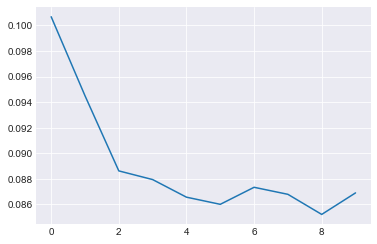

In [19]:
plt.plot(history.history['loss'])

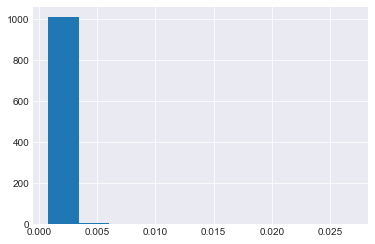

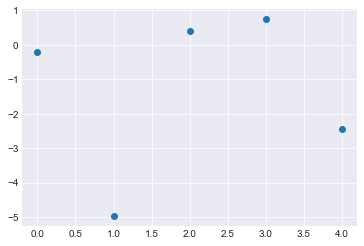

In [20]:
weights = model.traj_weights
plt.hist(weights)
plt.show()
plt.plot(model.lambdas.numpy(), 'o')

## Complete patch plots
disable if you want, they are very slow

In [21]:
#patch_quantile(trajs, figsize=(18, 14), alpha=0.6, names=['S', 'E', 'A', 'I', 'R'])
#plt.show()

In [22]:
#patch_quantile(trajs, weights=weights, figsize=(18, 14), alpha=0.6, names=['S', 'E', 'A', 'I', 'R'])
#plt.show()

## Final plots showing agreement

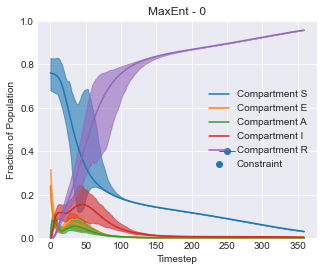

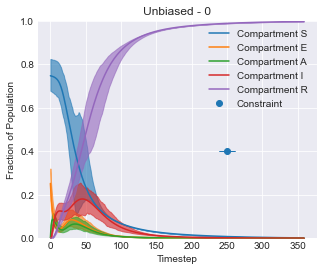

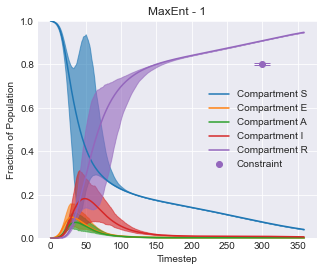

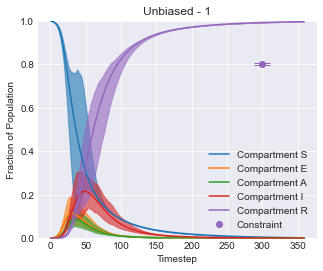

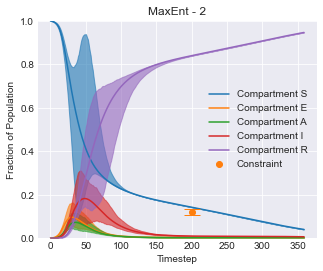

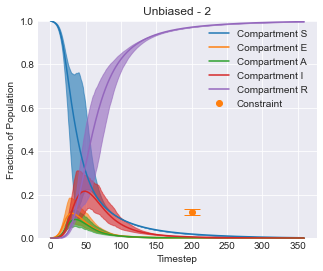

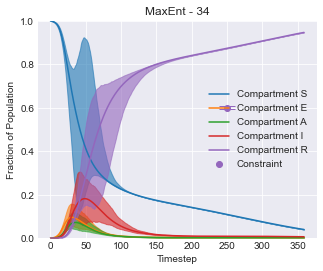

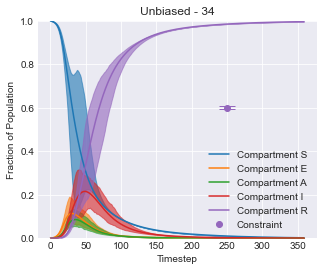

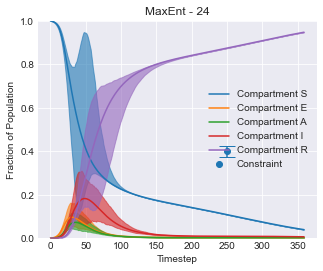

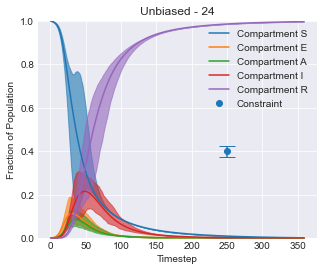

In [23]:
for p in [0,1,2,34,24]:
    plt.figure(figsize=(5,4))
    plt.title(f'MaxEnt - {p}')
    traj_quantile(trajs[:,:,p,:], weights, add_legend=False, names=['S', 'E', 'A', 'I', 'R'])
    for i, (pr, r) in enumerate(zip(laplace_restraints, restraints)):    
        if r[3] == p:
            plt.plot(r[2], r[0], 'o', color=f'C{int(r[-1])}', label='Constraint')
            plt.errorbar(r[2], r[0], yerr=pr.prior.expected(float(model.lambdas[i])), color=f'C{int(r[-1])}', capsize=8)
    plt.legend(loc='best')
    plt.ylim(0,1)
    plt.show()
    plt.figure(figsize=(5,4))
    plt.title(f'Unbiased - {p}')
    traj_quantile(trajs[:,:,p,:], add_legend=False, names=['S', 'E', 'A', 'I', 'R'])
    for i, (pr, r) in enumerate(zip(laplace_restraints, restraints)):    
        if r[3] == p:
            plt.plot(r[2], r[0], 'o', color=f'C{int(r[-1])}', label='Constraint')
            plt.errorbar(r[2], r[0], yerr=pr.prior.expected(float(model.lambdas[i])), color=f'C{int(r[-1])}', capsize=8)
    plt.legend(loc='best')
    plt.ylim(0,1)
    plt.show()